In [2]:
import numpy as np
import matplotlib.pyplot as plt
import galois
import itertools
from classical_code import *
from quantum_code import *
import stim
from scipy.sparse import lil_matrix
import scipy as sp
from ldpc import BpDecoder, BpOsdDecoder
from ldpc.bplsd_decoder import BpLsdDecoder
from tqdm import tqdm
from result_lifetime import Result, save_new_res

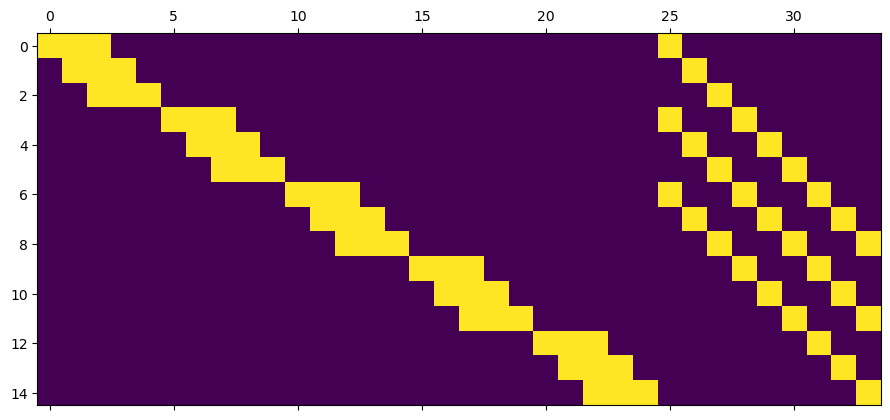

In [126]:
hgp_qcode = read_qcode("../codes/qcodes/lacross/HGP_34_4/HGP_34_4.qcode")
qcode = hgp_qcode
# qcode = read_qcode("../codes/qcodes/lacross/HGP_34_4/HGP_C422_68_4.qcode")


# hgp_qcode = read_qcode("../codes/qcodes/HGP_400_16/HGP_400_16.qcode")
# qcode = hgp_qcode
# qcode = read_qcode("../codes/qcodes/HGP_400_16/HGP_C422_800_16.qcode")


# hgp_qcode = read_qcode("../codes/qcodes/HGP_900_36/HGP_900_36.qcode")
# qcode = hgp_qcode
# qcode = read_qcode("../codes/qcodes/HGP_900_36/HGP_C422_1800_36.qcode")



hgp_Hx, hgp_Hz, hgp_Lx, hgp_Lz, _ = hgp_qcode.to_numpy()
Hx, Hz, Lx, Lz, mapping = qcode.to_numpy()

cn = qcode.n
cmx = qcode.xm
cmz = qcode.zm

tot_qbts = cn+cmx+cmz


qubit_error_rate = 0.01
meas_error_rate = 0.01

stab_type = False
tanner = True if meas_error_rate else False

H = Hx if stab_type else Hz
hgp_H = hgp_Hx if stab_type else hgp_Hz

# qed_dec_H = H[:qcode.qedxm]
# qed_channel_probs = [qubit_error_rate]*H.shape[1]

qec_aug_dec_H = np.hstack([hgp_H, np.eye(hgp_H.shape[0], dtype=int)])
qec_aug_channel_probs = [qubit_error_rate]*hgp_H.shape[1] + [meas_error_rate]*(hgp_H.shape[0])

qec_dec_H = hgp_H
qec_channel_probs = [qubit_error_rate]*hgp_H.shape[1]
L = Lx if stab_type else Lz

plt.matshow(qec_dec_H)
# print(np.count_nonzero(Hx, axis=1))

In [127]:
def find_pivots(N, Lx, Lz):
    # assuming full rank classical codes ...
    k = int(np.sqrt(len(Lx)))
    coeff = [2, -2*k, (k**2-N)]
    m, n = sorted(abs(np.roots(coeff).astype(int)))

    grid = np.arange(n**2).reshape(n,n)
    loc = np.empty(len(Lx), dtype=object)
    for i in range(len(Lx)):
        tmp = np.intersect1d(np.where(Lx[i])[0], np.where(Lz[i])[0])[0]
        loc[i] = (tmp//n, tmp%n)

    return grid, loc
grid, loc = find_pivots(qcode.n, Lx, Lz)
print(grid)
print(loc)

[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]]
[(3, 3) (3, 4) (4, 3) (4, 4)]


In [128]:
pivot_rows = set([ind[0] for ind in loc])
pivot_columns = set([ind[1] for ind in loc])

def Qp(Hx, Hz, cols):
    punctured_cols = pivot_columns - cols
    punctured_qbts = grid[:, list(punctured_cols)].flatten()

    mask = ~np.any(Hx[:, punctured_qbts] == 1, axis=1)
    # punc_Hx = Hx[mask]
    punc_Hx = Hx.copy()
    punc_Hx[~mask] = 0
    punc_Hz = Hz.copy()

    punc_Hx[:, punctured_qbts] = 0
    punc_Hz[:, punctured_qbts] = 0

    return punc_Hx, punc_Hz

def Qpp(Hx, Hz, rows):
    punctured_rows = rows
    punctured_qbts = grid[list(punctured_rows)].flatten()

    mask = ~np.any(Hz[:, punctured_qbts] == 1, axis=1)
    # punc_Hz = Hz[mask]
    punc_Hz = Hz.copy()
    punc_Hz[~mask] = 0
    punc_Hx = Hx.copy()

    punc_Hx[:, punctured_qbts] = 0
    punc_Hz[:, punctured_qbts] = 0

    return punc_Hx, punc_Hz

In [258]:
def prepare_code(Hx, Hz, qbts, stab_type):
    c = stim.Circuit()
    data_qbts, x_checks, z_checks = qbts

    if stab_type:
        c.append("H", [qbt for qbt in data_qbts])
        for z in np.arange(qcode.zm):
            gen_qbts = data_qbts[np.where(Hz[z])[0]]
            for qbt in gen_qbts:
                path_qbts = [qbt, z_checks[z]]
                c.append("CNOT", path_qbts)
        for i, z_check in enumerate(np.arange(Hz.shape[0])):
            c.append("MR", z_checks[z_check])
    else:
        c.append("H", x_checks)
        for x in np.arange(qcode.xm):
            gen_qbts = data_qbts[np.where(Hx[x])[0]]
            for qbt in gen_qbts:
                path_qbts = [x_checks[x], qbt]
                c.append("CNOT", path_qbts)
        c.append("H", x_checks)
        for i, x_check in enumerate(np.arange(Hx.shape[0])):
            c.append("MR", x_checks[x_check])

    return c

def get_qubits(cb):
    data_qbts = np.arange((cb*tot_qbts), cn+(cb*tot_qbts))
    x_checks = np.arange((cb*tot_qbts)+cn,(cb*tot_qbts)+(cn+cmx))
    z_checks = np.arange((cb*tot_qbts)+(cn+cmx),(cb*tot_qbts)+(cn+cmx+cmz))
    return (data_qbts, x_checks, z_checks)

def GPPM(log_qbts):
    c = stim.Circuit()

    rows = loc[log_qbts][0]
    cols = loc[log_qbts][1]

    Qp_Hx, Qp_Hz = Qp(Hx, Hz, {cols})
    Qpp_Hx, Qpp_Hz = Qpp(Qp_Hx, Qp_Hz, {rows})

    data_qbts1, _, _ = get_qubits(0)
    data_qbts2, _, _ = get_qubits(1)
    data_qbts3, _, _ = get_qubits(2)

    c += prepare_code(Hx, Hz, get_qubits(0), False)
    c.append("TICK")
    c.append("X", [3,13,18])
    # change logicals ...
    # c += prepare_code(Qp_Hx, Qp_Hz, get_qubits(1), False)
    c += prepare_code(Hx, Hz, get_qubits(1), False)
    c.append("TICK")
    c += prepare_code(Qpp_Hx, Qpp_Hz, get_qubits(2), True)
    c.append("TICK")

    nonzero1 = np.count_nonzero(Hx, axis=0)
    nonzero2 = np.count_nonzero(Qp_Hx, axis=0)
    nonzero3 = np.count_nonzero(Qpp_Hx, axis=0)

    # for i in range(Hx.shape[1]):
    #     if (nonzero2[i] and nonzero3[i]):
    #         c.append("CNOT", [data_qbts3[i], data_qbts2[i]])
    for i in range(Hx.shape[1]):
        if (nonzero1[i] and nonzero2[i]):
            c.append("CNOT", [data_qbts1[i], data_qbts2[i]])

    # measure Q' in the Z basis
    c.append("M", data_qbts2)

    return c

# def final_synd_and_observables():
    # c = stim.Circuit()

    # if stab_type: c.append("H", [qbt for qbt in data_qbts])
    # c.append("M", data_qbts)

#     s.do_circuit(c)

#     meas = s.current_measurement_record()
#     H = Hx if stab_type else Hz
#     for i in range(H.shape[0]):
#         incl_qbts = np.where(H[i])[0]
#         incl_qbts = np.array([j-cn for j in incl_qbts])

#         if stab_type:
#             x_syndrome_history[-1][i] = np.sum(np.take(meas, incl_qbts)) % 2
#         else:
#             z_syndrome_history[-1][i] = np.sum(np.take(meas, incl_qbts)) % 2

#     for i, logical in enumerate(Lx if stab_type else Lz):
#         incl_qbts = np.where(logical)[0]
#         incl_qbts = [j-cn for j in incl_qbts]

#         if stab_type:
#             x_observables[i] = (np.sum(np.take(meas, incl_qbts)) % 2)
#         else:
#             z_observables[i] = (np.sum(np.take(meas, incl_qbts)) % 2)

GPPM(0)


stim.Circuit('''
    H 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
    CX 34 0 34 5 34 10 34 25 35 1 35 6 35 11 35 25 35 26 36 2 36 7 36 12 36 25 36 26 36 27 37 3 37 8 37 13 37 26 37 27 38 4 38 9 38 14 38 27 39 5 39 10 39 15 39 28 40 6 40 11 40 16 40 28 40 29 41 7 41 12 41 17 41 28 41 29 41 30 42 8 42 13 42 18 42 29 42 30 43 9 43 14 43 19 43 30 44 10 44 15 44 20 44 31 45 11 45 16 45 21 45 31 45 32 46 12 46 17 46 22 46 31 46 32 46 33 47 13 47 18 47 23 47 32 47 33 48 14 48 19 48 24 48 33
    H 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
    MR 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
    TICK
    X 3 13 18
    H 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112
    CX 98 64 98 69 98 74 98 89 99 65 99 70 99 75 99 89 99 90 100 66 100 71 100 76 100 89 100 90 100 91 101 67 101 72 101 77 101 90 101 91 102 68 102 73 102 78 102 91 103 69 103 74 103 79 103 92 104 70 104 75 104 80 104 92 104 93 105 71 105 76 105 81 105 92 105 93 105 94 106 72 106 77 106 82 106 93 106 94 107 73 107 7

In [269]:
s = stim.TableauSimulator()

c = GPPM(0)
s.do_circuit(c)

z_observables = np.zeros(qcode.k, dtype=int)
x_observables = np.zeros(qcode.k, dtype=int)

stab_type = False

meas = s.current_measurement_record()
for i, logical in enumerate(Lx if stab_type else Lz):
    incl_qbts = np.where(logical)[0]
    incl_qbts = [j-cn for j in incl_qbts]

    # if stab_type:
    #     x_observables[i] = (np.sum(np.take(meas, incl_qbts)) % 2)
    # else:
    z_observables[i] = (np.sum(np.take(meas, incl_qbts)) % 2)

z_observables

array([1, 0, 1, 0])

In [257]:
qbt_meas = meas[-34:]
print(np.array(qbt_meas).astype(int)[18])

0


In [203]:
log_qbts = 0
rows = loc[log_qbts][0]
cols = loc[log_qbts][1]

Qp_Hx, Qp_Hz = Qp(Hx, Hz, {cols})
Qpp_Hx, Qpp_Hz = Qpp(Qp_Hx, Qp_Hz, {rows})

print(np.count_nonzero(Qp_Hx, axis=0))
print(np.count_nonzero(Qp_Hz, axis=0))
print(np.where(np.count_nonzero(Qp_Hx, axis=0) == 0)[0])

[1 1 1 1 0 2 2 2 2 0 3 3 3 3 0 2 2 2 2 0 1 1 1 1 0 3 3 2 3 3 2 3 3 2]
[1 2 3 2 0 1 2 3 2 0 1 2 3 2 0 1 2 3 2 0 1 2 3 2 0 3 3 3 3 3 3 3 3 3]
[ 4  9 14 19 24]


In [202]:
np.where(Lz[0])[0]

array([ 3, 13, 18], dtype=int64)

In [ ]:



z_syndrome_history = np.zeros(shape=(2, cmz), dtype=int)
x_syndrome_history = np.zeros(shape=(2, cmx), dtype=int)
z_observables = np.zeros(qcode.k, dtype=int)
x_observables = np.zeros(qcode.k, dtype=int)

stab_type = True
c = prepare_code(Hx, Hz, get_qubits(1), stab_type)
s = stim.TableauSimulator()

s.do_circuit(c)
if stab_type:
    z_syndrome_history[0] = s.current_measurement_record()
else:
    x_syndrome_history[0] = s.current_measurement_record()


array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])